In [1]:
!pip -q install transformers

In [2]:
import os
import re
import glob
import torch
import shutil
import pickle
import random
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm, trange
from statistics import mean, median, stdev
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

In [3]:
# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [4]:
class Args():
    def __init__(self):
        self.output_dir = 'output'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

### Data

In [5]:
! gdown https://drive.google.com/uc?id=1Lp-diuMohUTGyB9BSTFgeGZyY3dkNuEg

Downloading...
From: https://drive.google.com/uc?id=1Lp-diuMohUTGyB9BSTFgeGZyY3dkNuEg
To: /content/final_es_conv.csv
20.3MB [00:00, 64.6MB/s]


In [6]:
df = pd.read_csv('final_es_conv.csv')
df = df.dropna()
trn_df, val_df = train_test_split(df, test_size = 0.2)
trn_df.head()

,response,context,context/0,context/1,context/2,context/3,context/4,context/5,context/6,context/7,context/8,context/9
40223,¿Lo cree?,¿Lo cree?,¿Ud. cree que Leonard Vole es inocente?,Déjeme preguntarle una cosa.,Lo cierto es que no tengo nada.,"No tengo mucho con qué continuar, ¿verdad?",Nosotros de un lado y todas las probabilidades...,La carga de la caballería ligera o uno de esos...,Llevar este caso será cómo :,La acusación acabará con ella en cuanto la sub...,"La mujer busca algo, ¿pero qué?",¿Quiere acompañarme a oler esas sales?
42067,¡Condición Roja!,¡Alarma Roja!,¡Condición Roja!,"¡Operaciones, habla el Coronel Parkman!","¡Sí, señor!",¡Oprima el Botón de Alerta!,"Bueno, se debe a que la vibración de... un son...",Usted sabe cómo los escaladores de montañas le...,"Oh, cualquier clase de vibraciones inusuales.","Bueno, ¿y que pudo liberarla después de todo e...",Pudo haber estado encerrada en una prisión... ...,¿Quién puede estar seguro?
43758,Y ahora date prisa y decir adiós.,Estoy seguro de ello.,¿Lo crees así?,Estoy convencido de que va a encontrar un prof...,"Ahora que hablo portugués, tengo que aprender ...","Tan pronto como supe húngaro, fuimos a Madeira.","Pero, mayor!","Condesa, por favor, sabes que adoro nuestra Em...",Para Grecia?,Para Grecia.,"Pero, ¿dónde?",¿Otra vez?
20337,Catherine.,Catherine.,El bombardeo parece que ha terminado.,"Si no le importa, me gustaría irme.","Será mejor que te calces, antes de que se te e...",La arquitectura es el arte más antiguo del mundo.,"En resumen, querida...",La misma palabra indica la íntima unión de est...,Arquitectura.,Arco.,"El arco, querida, puede que sea el elemento ar...","Esto, querida, se llama arco."
12886,iDudo que sepáis lo que es eso!,Tal vez esta sea nuestra idea de la decencia.,"No como vosotros, que sólo queréis burlaros de...",Por lo menos era decente.,Sabía cómo manejar a la gente.,Menos a Okayo.,Conocía bien la gente.,Era muy amable y lo sabía todo.,"Pues sí, yo quería al anciano.",Para Osen fue amor a primer a vista.,"Además, era muy agudo.",Tienes razón.


In [7]:
def get_counter_and_lens(data, tokenizer):
    flatten = lambda l: [item for sublist in l for item in sublist]
    toks = [tokenizer.tokenize(x) for x in data]
    
    return list(map(len, toks)), Counter(flatten(toks)), Counter(' '.join(data).split())

In [8]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, cache_dir = args.cache_dir)
lens, tok_cnt, word_cnt = get_counter_and_lens(trn_df[df.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1), tokenizer)

In [9]:
def plot_counts(counts, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

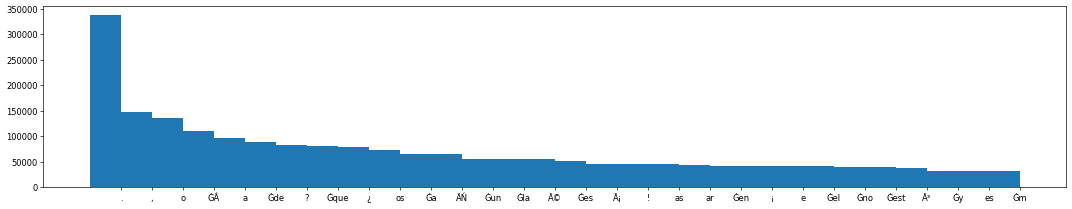

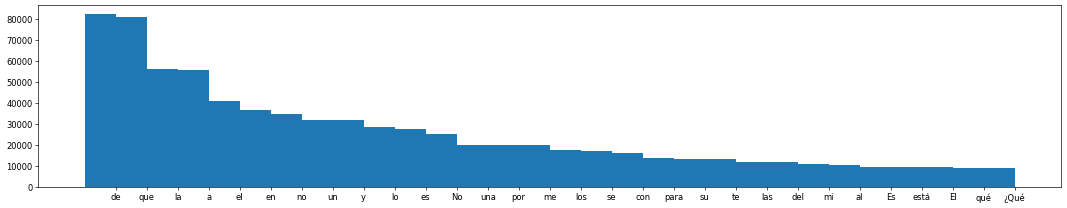

In [10]:
plot_counts(tok_cnt, top_k = 30)
plot_counts(word_cnt, top_k = 30)

In [11]:
def plot_hist(lens, n_bins = 50):
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

Mean: 149.96752860751968, Median: 141.0, Standard Deviation: 44.832972834170754, 90th Percentile: 513.0


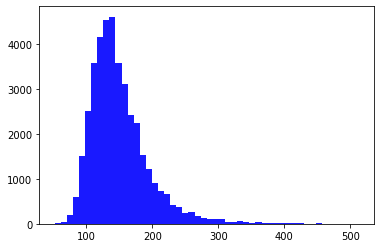

In [12]:
print(f'Mean: {mean(lens)}, Median: {median(lens)}, Standard Deviation: {stdev(lens)}, 90th Percentile: {np.percentile(lens, 100)}')
plot_hist(lens)